In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import gseapy as gp
import seaborn as sns

from tqdm import tqdm
from scripts import constants

In [2]:
dataset = "mcfarland_2020"

In [3]:
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes.h5ad",
    )
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
target_indices = np.where(
    (adata.obs["condition"] != "DMSO") & (adata.obs["TP53_mutation_status"] == "Wild Type")
)[0]

In [5]:
genes = pd.read_table(
    os.path.join(
        "/projects/leelab/data/single-cell/mcfarland_2020",
        "idasanutlin/Idasanutlin_24hr_expt1",
        "genes.tsv",
    ),
    header=None,
)
genes = genes.rename(columns={0: "ensembl_id", 1: "gene_symbol"})
genes = genes[genes["ensembl_id"].isin(adata.var.index)]

In [6]:
"TP53" in genes["gene_symbol"]

False

In [7]:
seeds = [123, 42, 789, 46, 999]
latent_size = 10
result_list = []

for seed in tqdm(seeds):
    background_expr = np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}",
            "background_normalized_expression.npy",
        ),
    )
    salient_expr = np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}",
            "salient_normalized_expression.npy",
        ),
    )
    background_expr = background_expr[target_indices, :]
    salient_expr = salient_expr[target_indices, :]
    
    expr_mag_change = np.abs(salient_expr - background_expr)
    expr_mag_logfc = np.abs(np.log2(salient_expr / background_expr))
    
    results = genes.copy()
    results["mag_change_mean"] = np.mean(expr_mag_change, axis=0)
    results["mag_change_median"] = np.median(expr_mag_change, axis=0)
    results["mag_logfc_mean"] = np.mean(expr_mag_logfc, axis=0)
    results["mag_logfc_median"] = np.median(expr_mag_logfc, axis=0)
    results["seed"] = seed
    result_list.append(results)

results = pd.concat(result_list)
results = results.drop(columns=["ensembl_id"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


In [8]:
result_means = results.groupby("gene_symbol", as_index=False).mean().drop(columns=["seed"])

In [9]:
metric_list = [
    "mag_change_mean",
    "mag_change_median",
    "mag_logfc_mean",
    "mag_logfc_median",
]

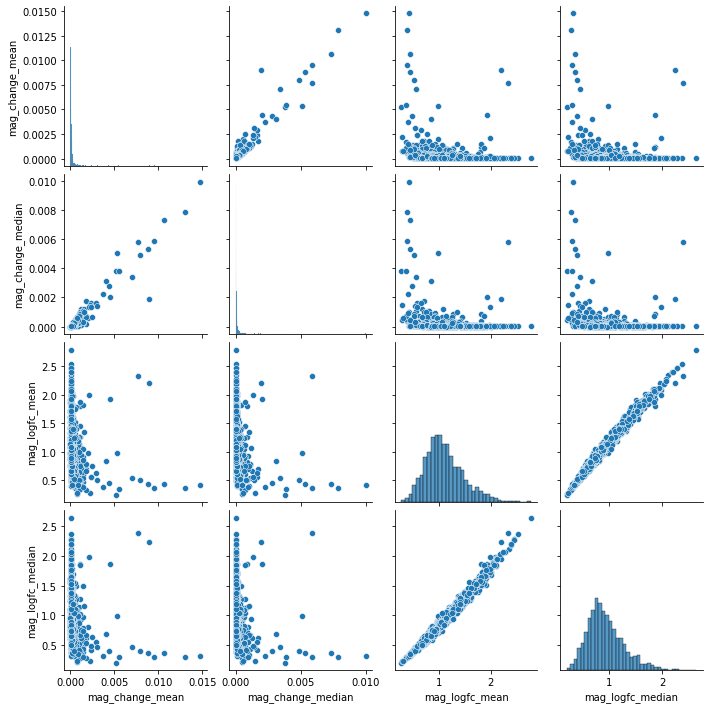

In [10]:
sns.pairplot(result_means[metric_list])

In [11]:
enr_result_dict = {}
top_gene_dict = {}
top_k = 100
for metric in metric_list:
    print(metric)
    sorted_genes = result_means.sort_values(by=metric, ascending=False)
    top_genes = sorted_genes.head(n=top_k)["gene_symbol"].tolist()
    enr = gp.enrichr(
        gene_list=top_genes,
        gene_sets="KEGG_2016",
        organism="human",
        cutoff=0.1,
    )
    enr_results = enr.results
    enr_results = enr_results[enr_results["Adjusted P-value"] < 0.1]
    enr_results = enr_results.sort_values(by="Adjusted P-value")
    
    enr_result_dict[metric] = enr_results
    top_gene_dict[metric] = top_genes

mag_change_mean
mag_change_median
mag_logfc_mean


2021-11-17 22:48:05,482 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.1


mag_logfc_median


2021-11-17 22:48:07,991 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.1


In [12]:
enr_result_dict["mag_change_mean"]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,p53 signaling pathway Homo sapiens hsa04115,7/69,5.286604e-08,0.000008,0,0,24.083593,403.532763,CDKN1A;CCND3;TP53I3;CCND1;GADD45A;IGFBP3;MDM2
1,KEGG_2016,Glycolysis / Gluconeogenesis Homo sapiens hsa0...,6/67,1.047148e-06,0.000075,0,0,20.759330,285.844359,LDHA;TPI1;PKM;ENO1;ALDOA;GAPDH
2,KEGG_2016,Prostate cancer Homo sapiens hsa05215,6/89,5.580858e-06,0.000268,0,0,15.239938,184.344857,CDKN1A;HSP90AA1;CCND1;GSTP1;MDM2;KLK3
3,KEGG_2016,Viral carcinogenesis Homo sapiens hsa05203,8/205,8.823943e-06,0.000318,0,0,8.696976,101.215774,RANBP1;CCND3;CDKN1A;PKM;CCND1;HIST1H2BK;MDM2;H...
4,KEGG_2016,HIF-1 signaling pathway Homo sapiens hsa04066,6/103,1.298024e-05,0.000374,0,0,13.031147,146.627545,LDHA;CDKN1A;EIF4EBP1;ENO1;ALDOA;GAPDH
5,KEGG_2016,Biosynthesis of amino acids Homo sapiens hsa01230,5/74,3.462786e-05,0.000831,0,0,15.126621,155.363284,TPI1;PKM;ENO1;ALDOA;GAPDH
6,KEGG_2016,Ribosome Homo sapiens hsa03010,6/137,6.508419e-05,0.001339,0,0,9.632451,92.855178,RPS4X;RPL23;RPS27L;RPL22L1;RPS4Y1;RPL19
7,KEGG_2016,Mineral absorption Homo sapiens hsa04978,4/51,1.227619e-04,0.002210,0,0,17.600177,158.494233,MT2A;FTH1;MT1X;FTL
8,KEGG_2016,Carbon metabolism Homo sapiens hsa01200,5/113,2.587519e-04,0.004127,0,0,9.645224,79.666088,TPI1;PKM;ENO1;ALDOA;GAPDH
9,KEGG_2016,PI3K-Akt signaling pathway Homo sapiens hsa04151,8/341,3.137033e-04,0.004127,0,0,5.109544,41.219016,COL1A1;CCND3;HSP90AA1;CDKN1A;CCND1;SPP1;MDM2;E...


In [13]:
enr_result_dict["mag_logfc_median"]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
